In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import nibabel as nib

from tensorflow import keras
from tensorflow.keras import layers

from scipy import ndimage

2022-04-12 18:43:21.422613: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-2021.05-5tjen3mrle3pnguoedh4n2stzzsmywn7/lib
2022-04-12 18:43:21.422633: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


In [3]:
scan_paths = [
    os.path.join(os.getcwd(), "data/BET_BSE_DATA", x)
    for x in os.listdir("data/BET_BSE_DATA")
]

print("Brain scans: " + str(len(scan_paths)))
print(scan_paths)

Brain scans: 3
['/home/rgoli/clemson/cpsc-8650/Project/data/BET_BSE_DATA/files', '/home/rgoli/clemson/cpsc-8650/Project/data/BET_BSE_DATA/.ipynb_checkpoints', '/home/rgoli/clemson/cpsc-8650/Project/data/BET_BSE_DATA/Label_file.csv']


In [4]:
import csv
 
# csv file name
filename = "data/BET_BSE_DATA/Label_file.csv"
 
# initializing the titles and rows list
fields = []
labels_dict = dict()
 
# reading csv file
with open(filename, 'r') as csvfile:
    # creating a csv reader object
    csvreader = csv.reader(csvfile)
     
    # extracting field names through first row
    fields = next(csvreader)
 
    # extracting each data row one by one
    for row in csvreader:
        #print(row)
        if row[1].lower() == 'yes':
            labels_dict[row[0]+'.gz'] = 1
        else:
            labels_dict[row[0]+'.gz'] = 0
 
    # get total number of rows
    print("Total no. of rows: %d"%(csvreader.line_num))

# printing the field names
print('Field names are:' + ', '.join(field for field in fields))
#print(labels_dict)

Total no. of rows: 1312
Field names are:Filename, Recognizable-Facial-Feature, Brain-Feature-Loss


In [5]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [6]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
brain_scans=[]
labels_facial_feature=[]
labels_to_file=[]
for path in os.listdir("data/BET_BSE_DATA/files"):
    #brain_scans.append(process_scan("data/BET_BSE_DATA/files/"+path))
    labels_facial_feature.append(labels_dict[path])
    labels_to_file.append(path)

In [7]:
#brain_scans_np = np.array(brain_scans)
labels_facial_feature_np = np.array(labels_facial_feature)

# with open('brain_scans_np.npy', 'wb') as f:
#     np.save(f, brain_scans_np)

brain_scans_np=np.load('brain_scans_np.npy')

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(brain_scans, labels_facial_feature, test_size=0.20, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.20, random_state=42)


In [13]:
!module list


Currently Loaded Modules:
  1) anaconda3/2021.05-gcc/8.3.1

 



In [12]:
!module load anaconda3/2021.05-gcc/8.3.1 cudnn/8.1.0.77-11.2-linux-x64-gcc/8.4.1 cuda/11.2.0-gcc/8.4.1

In [14]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [16]:
print("Is cuda available?", tf.test.is_built_with_cuda())

print("Is GPU available?", tf.test.is_gpu_available(cuda_only=False,min_cuda_compute_capability=None))
# print("cuDNN enabled? ", torch.backends.cudnn.enabled)
      
tf.config.list_physical_devices('GPU')

Is cuda available? True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available? False


2022-04-12 19:23:29.719882: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

labels tf.Tensor([1 0], shape=(2,), dtype=int32) <TakeDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
Dimension of the CT scan is: (128, 128, 64, 1)


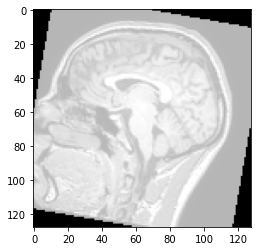

In [51]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("labels", labels, data)
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [19]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

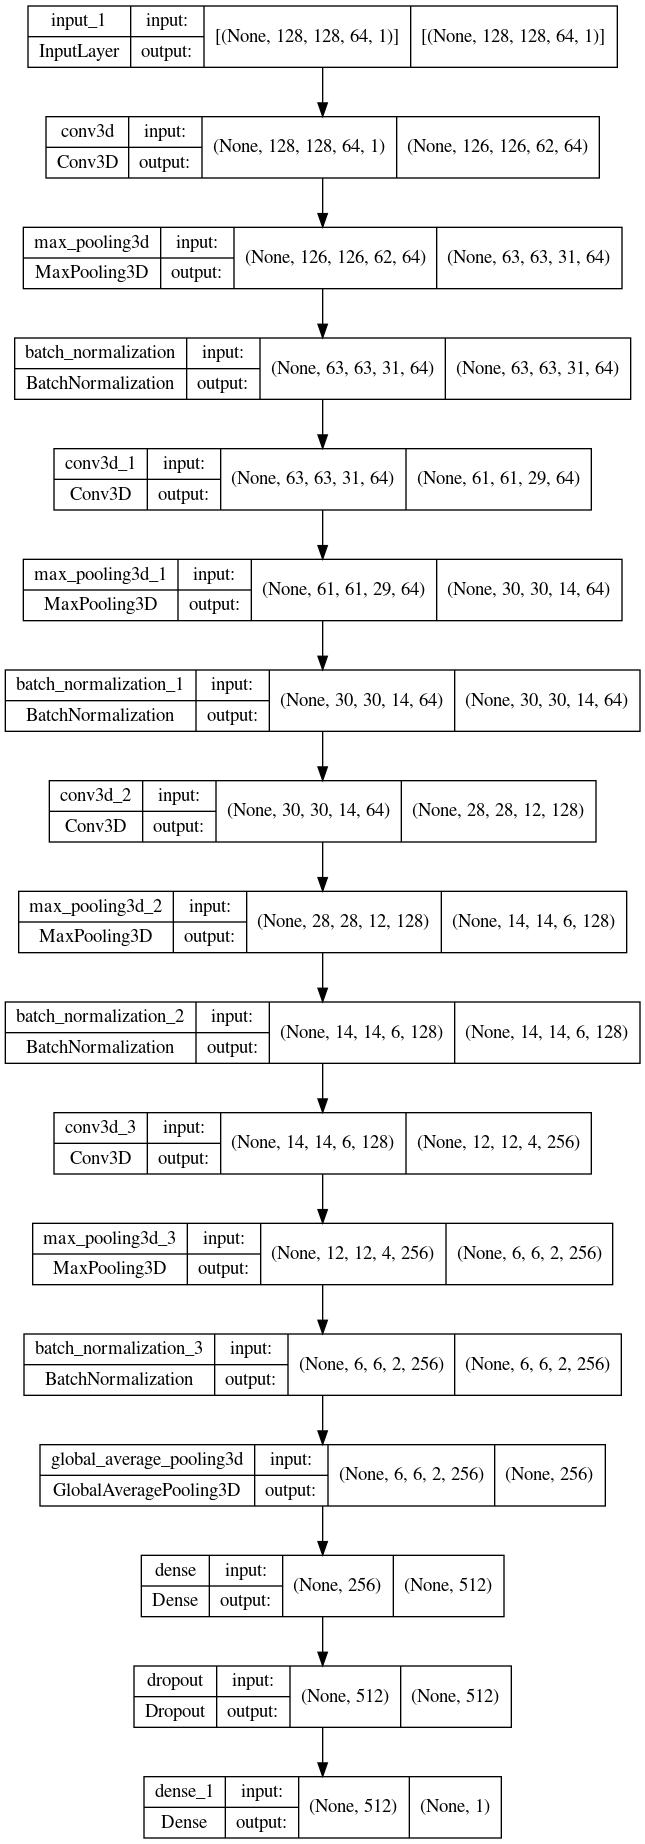

In [22]:
tf.keras.utils.plot_model(model, to_file='mri_keras_facial_feature.png', show_shapes=True)

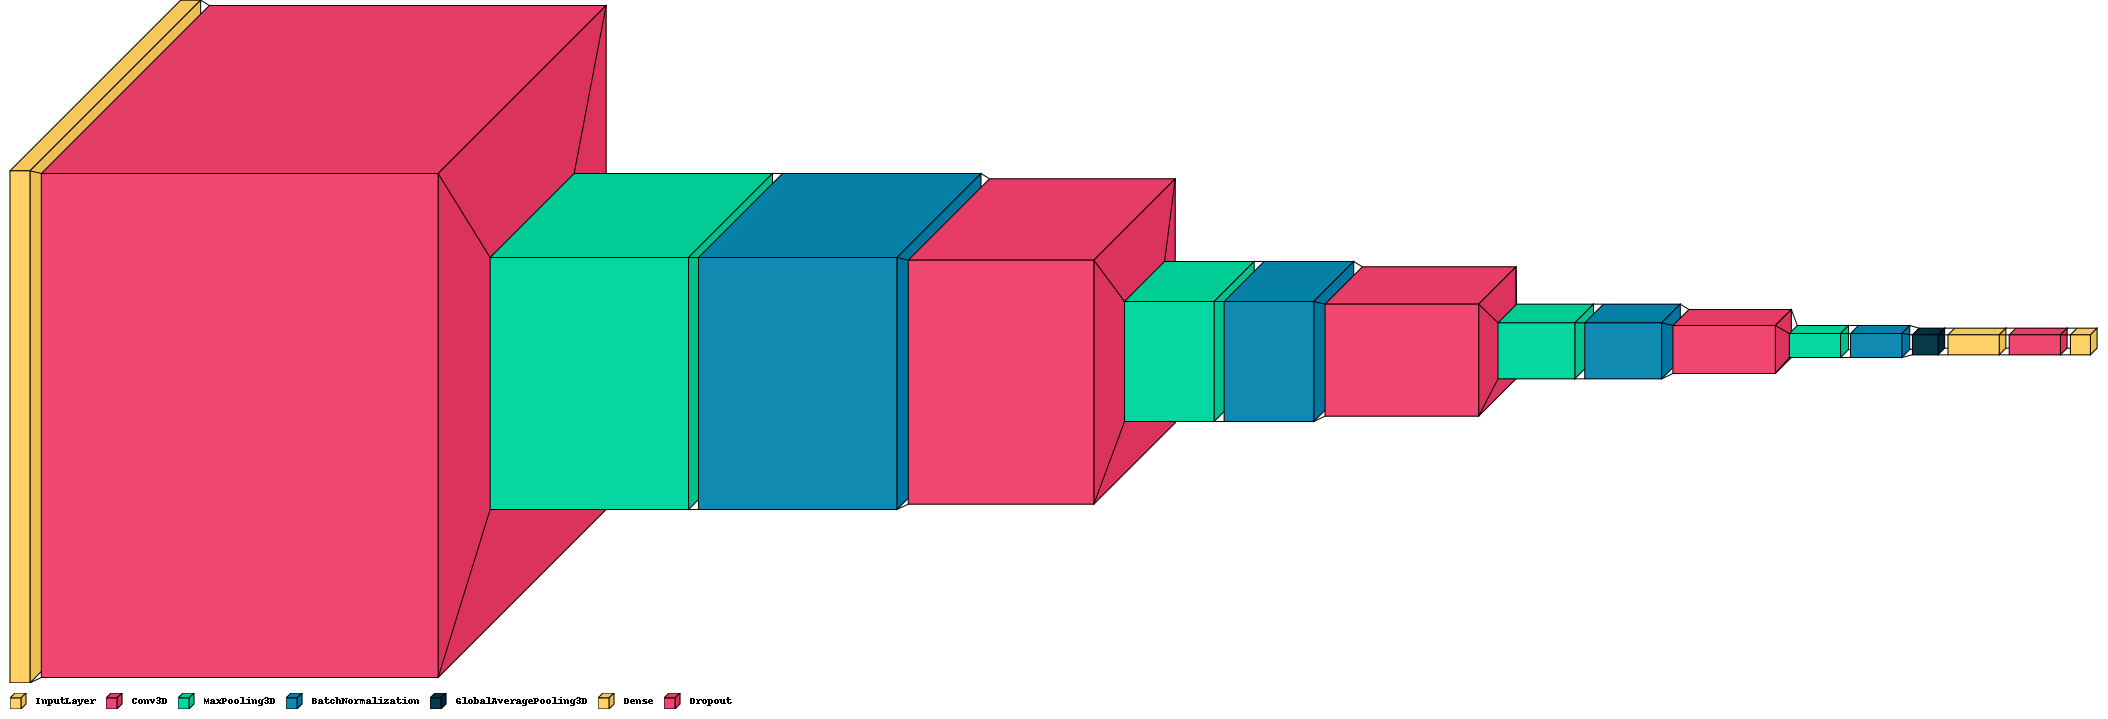

In [4]:
import visualkeras
visualkeras.layered_view(model, to_file='mri_keras_facial_featurev2.png', legend=True)

In [24]:
# from ann_visualizer.visualize import ann_viz

# ann_viz(model, title="MRI_Keras_Facial_Feature")

In [25]:
model.load_weights("3d_brain_image_classification.h5")

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_brain_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
524/524 [==============================] - 6136s 12s/step - loss: 0.3667 - acc: 0.7948 - val_loss: 0.1727 - val_acc: 0.9620
Epoch 2/100
524/524 [==============================] - 6130s 12s/step - loss: 0.2695 - acc: 0.8979 - val_loss: 0.0688 - val_acc: 0.9848
Epoch 3/100
524/524 [==============================] - 6126s 12s/step - loss: 0.2207 - acc: 0.9351 - val_loss: 0.0879 - val_acc: 0.9848
Epoch 4/100
210/524 [===========>..................] - ETA: 1:01:01 - loss: 0.1675 - acc: 0.9429

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])


In [10]:
model.load_weights("3d_brain_image_classification.h5")

In [26]:
for i in range(20):
    prediction = model.predict(np.expand_dims(brain_scans_np[i], axis=0))[0]
    print("Scan File: ", labels_to_file[i], ", Actual: ", labels_facial_feature_np[i], ", Predicted: ",round(float(prediction)))


Scan File:  IXI369-Guys-0924-T1_bse_high_s75_r2.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI270-Guys-0847-T1_bet_88.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI333-IOP-0926-T1_bse_default.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI483-HH-2177-T1_bet_12.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI464-IOP-1029-T1_bet_08.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI205-HH-1649-T1_bet_73.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI544-HH-2395-T1_bse_less_s51_r1.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI033-HH-1259-T1_bet_76.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI260-HH-1805-T1_bet_12.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI241-Guys-0833-T1_bse_high_s74_r2.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI569-Guys-1101-T1_bse_high_s75_r2.nii.gz , Actual:  0 , Predicted:  0
Scan File:  IXI635-HH-2691-T1_bet_12.nii.gz , Actual:  1 , Predicted:  1
Scan File:  IXI639-Guys-1088-T1_bet_85.nii.gz , Actual:  0 , Predicted:  

In [27]:
len(labels_to_file)

1311

In [28]:
y_preds = []
for i in range(len(labels_to_file)):
    prediction = model.predict(np.expand_dims(brain_scans_np[i], axis=0))[0]
    y_preds.append(round(float(prediction)))

In [33]:
print(lens(labels_facial_feature_np))

1311


In [34]:
y_preds = np.array(y_preds)
print(len(y_preds))

1311


In [39]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

results = confusion_matrix(labels_facial_feature_np, y_preds)

In [40]:
results

array([[614,   5],
       [ 14, 678]])

In [42]:
print(classification_report(labels_facial_feature_np, y_preds))
print("Accuracy: {}".format(accuracy_score(labels_facial_feature_np, y_preds)))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       619
           1       0.99      0.98      0.99       692

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311

Accuracy: 0.9855072463768116


In [43]:
brain_scans_np.shape

(1311, 128, 128, 64)

In [44]:
brain_scans_np[0].shape

(128, 128, 64)

In [47]:
brain_scans_np[0][64]

array([[0.71428573, 0.71428573, 0.71428573, ..., 0.71428573, 0.71428573,
        0.71428573],
       [0.71428573, 0.71428573, 0.71428573, ..., 0.71428573, 0.71428573,
        0.71428573],
       [0.71428573, 0.71428573, 0.71428573, ..., 0.71428573, 0.71428573,
        0.71428573],
       ...,
       [0.71428573, 0.71428573, 0.71428573, ..., 0.71428573, 0.71428573,
        0.71428573],
       [0.71428573, 0.71428573, 0.71428573, ..., 0.71428573, 0.71428573,
        0.71428573],
       [0.71428573, 0.71428573, 0.71428573, ..., 0.71428573, 0.71428573,
        0.71428573]], dtype=float32)

In [46]:
brain_scans_np[0][1][64][32]

0.71428573